<a href="https://colab.research.google.com/github/billpottle/atari-dqn/blob/master/Atari_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A basic tensorflow 2.0 implementation of some of the ideas in DeepMind's papers, "[Human Level Control Through Deep Reinforcement Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)" and [Playing Atari with Deep Reinforcement Learning](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learningusing) Deep Q Learning to play Atari games. 

**References** - While the papers themselves are of course the most important references, I owe a lot to various reference implementations, notably Phil Tabor's [youtube video](https://www.youtube.com/watch?v=a5XbO5Qgy5w) and [Udemy Course](https://www.udemy.com/course/deep-q-learning-from-paper-to-code/). Although it is in tensorflow 1, I highly recommend this [extremely thorough explanation](https://colab.research.google.com/github/fg91/Deep-Q-Learning/blob/master/DQN.ipynb) with code that trains very quickly. I also recommend this [great medium article ](https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26)

You can follow along and run the code by clicking on the 'play' icon to the left of each cell, or click 'Run all' from the runtime menu. 

The first thing we will do is import the various libraries that we will need. 

In [1]:
%tensorflow_version 2.x
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]
%pip install -U autorom

import tensorflow as tf
# from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
import os
import imageio
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import gym
from skimage.transform import resize
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import math

1.22.2


Next we will set our global variables. You can play around with different values and try to get a new high score. The network should be able to [train any available Atari game](https://gym.openai.com/envs/#atari). We usually want the deterministic-v4 environments. Make sure whichever game you want is the only one not commented out. Although this should be able to train any game, the model is game specific. A model trained on one game can't play other games. 

Variables in all caps are constants that don't change during the run. You can change them and see how it changes the results and training time. Don't change anything in lower case, as the program will change them during the run. 

In [2]:
ENV_NAME = 'PongNoFrameskip-v4'				# Valid ATARI Game. For example: PongNoFrameskip-v4, BreakoutDeterministic-v4, MsPacmanNoFrameskip-v4, KungFuMasterNoFrameskip-v4

PATH = "output/"  							# Where to save the model and gif files
os.makedirs(PATH, exist_ok=True)
LOAD_CHECKPOINT 		= False 			# In case you want to save a model file and then train it more later. 
LOAD_FILE 				= 'atari_model.h5' 	# Filename 

EVALUATION_FREQUENCY 	= 60				# Evaluate model once every ... games
SAVE_FREQUENCY 			= 100				# Save model once every ... games
MODEL_COPY_FREQUENCY 	= 3					# Copy model once every ... games

MAX_MEMORY_LENGTH		= 15000 			# Size of the memory in frames. Reduce this if you get out of RAM errors
BATCH_SIZE			 	= 32 				# How many memory samples to train on

NUM_GAMES 				= 2000 				# Reduce this if it takes too long to train, increase it if you need more time to learn. 

FRAME_HEIGHT 			= 80 				# Smaller frames reduce training time but could lose info
FRAME_WIDTH 			= 80 				# Especially for smaller items like knives or dots 

INITIAL_EXP 			= 15000 			# Number of random actions to start out with
EPS_MIN 				= 0.05 				# Mimimum chance to take a random action
EPS_DEC 				= 0.00001 			# Amount to decrease random chance every frame

ALPHA 					= 0.0001 			# Learning rate -  how fast network parameters are updated. Increasing this will let you learn faster, but you may 'overshoot'
GAMMA 					= 0.99 				# Future reward discount

eps 			= 1.0 		# Chance to take a random action
n_frames 		= 0 		# The cumulative number of frames the agent has seen
evaluation 		= False 	# Don't change here, it will
frames_for_gif 	= []		# Array to store gif frames



device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# NOT NECESSARY ON M1 MACS: GPU is automatically detected
# We define this function so recent versions of keras and tf will work together
# def _get_available_gpus():
#   #global _LOCAL_DEVICES
#   if tfback._LOCAL_DEVICES is None:
#     devices = tf.config.list_logical_devices()
#     tfback._LOCAL_DEVICES = [x.name for x in devices]
#   return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]
# tfback._get_available_gpus = _get_available_gpus



This type of training would take a LONG time on even the fastest CPU. GPUs developed for video games are good at doing many simple things at once, and thus they are indispensible for training neural networks. Under Runtime, go to 'Change runtime type' and make sure you are using a GPU. The following code will tell you which GPU you have. 

Google will assign you one and let you use it for up to 12 hours. For $10/mo, [Colab Pro](https://colab.research.google.com/signup), will give you more powerful GPUs, more memory, and 24 hour runtimes. 

In [27]:
# Only for Google Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

**Random Agent** - The following code has a Random Agent play the game and then displays the last frame of the game. This can be useful if you are thinking about cropping the image to remove things like the score, level, or health bars.



To play this game, on each frame the player chooses one of 6 possible actions:
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


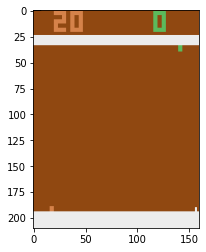

In [ ]:
# Create the environment
env = gym.make(ENV_NAME).env
# Reset it, returns the starting frame
frame = env.reset()
print("To play this game, on each frame the player chooses one of {} possible actions:".format(env.action_space.n))
print("{}".format(env.unwrapped.get_action_meanings()))
done = False
while not done:
  # Perform a random action, returns the new frame, reward and whether the game is over
  frame, reward, done, info = env.step(env.action_space.sample())
env.close() 
plt.imshow(frame)

Going from 3 channels (RGB) to 1 (BW) gives us a 3x reduction in size. Cropping and scaling from 210 X 160 to 80 X 80 gives us a further 5.25 reduction in size. So we can train something in 1 day that would take 15.75 days on a full frame. 

Original Frame Size: (210, 160, 3)


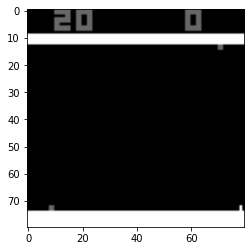

In [ ]:
print("Original Frame Size:", frame.shape)
processed = tf.image.rgb_to_grayscale(frame)
processed = tf.image.resize(processed,[FRAME_HEIGHT, FRAME_WIDTH],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
processed = np.asarray(processed).reshape(FRAME_HEIGHT,FRAME_WIDTH)
processed = np.asarray(processed)
plt.gray()
plt.imshow(processed) 

**Exploration vs Exploitation** - Say there are 100 restaurants in your town. You've been to the 10 nearby, and really like 2 or 3. When you finally get that date night, do you hit up one that you know will be good, or do you venture out to try something new? If you never try something new, there is a 90% chance that you will miss the best restaurant out there. 

Our agent has a similar issue. Should it try the move it thinks is best, or try a random move with the chance to come up with a better strategy? 

The following code will tell it which to do - When we start out, we are going to do only random actions. After some amount of time, we are going to slowly decrease the amount of random actions we take. We will reach a plateau, though, because we always want to be taking at least a few random chances. 

Of course, during evaulation mode, we want the agent to only do what it thinks is best, so we will never take random actions when we are testing. 

In [3]:
def ExplorerExploiter():

  # Never take a random action during evaluation games
  if evaluation: 
    return 'Exploit'

  # Take only random actions during initial exploration phase
  if n_frames < INITIAL_EXP:
    return 'Explore'

  # Explore with chance eps
  if np.random.random() < eps:
    return 'Explore'

  # Otherwise exploit
  return 'Exploit'

The main idea behind deep Q learning is to create a neural network that takes the pixels of the game board in as input and outputs the best action. The final output layer has one node for each possible action - the value of the node for the input pixels is what value we expect to get from taking that action (ie, fire, jump, turn left) in the given state (input of all pixels on the screen). **When training, we continually adjust the network so that the weights are close to the actual value received for taking a move in a given state.** Then, for new states, we pick the move that network says will give us the highest reward + future reward. 

We could train on each frame or game, but it's much more effecient to create a Memory that has a large number of previous frames and their results. When training, we simply sample from that memory.

Each 'memory' consists of the state (pixels), what action we took, what reward we got, what the next state was, and whether or not the game ended. If you are running the notebook and crash due to a memory error, you should still be able to get good results with a smaller memory.

In [4]:
class ExperienceMemory(object):
  def __init__(self, max_memory_length):
      self.state_memory = deque(maxlen=max_memory_length)
      self.action_memory = deque(maxlen=max_memory_length)
      self.reward_memory = deque(maxlen=max_memory_length)
      self.next_state_memory = deque(maxlen=max_memory_length)
      self.done_memory = deque(maxlen=max_memory_length)
      
  def get_length(self):
      return len(self.state_memory)

  # Store a new memory    
  def store_transition(self, state, action, reward, next_state, done):
      self.state_memory.append(state)
      self.action_memory.append(action)
      self.reward_memory.append(reward)
      self.next_state_memory.append(next_state)
      self.done_memory.append(done)

  # Get out batch_size samples from the memory
  def sample_buffer(self, batch_size):
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
  
    for i in range(batch_size):
      sample_id  = np.random.randint(len(self.state_memory))
      states.append(self.state_memory[sample_id])
      actions.append(self.action_memory[sample_id])
      rewards.append(self.reward_memory[sample_id])
      next_states.append(self.next_state_memory[sample_id])
      dones.append(self.done_memory[sample_id])

    return np.asarray(states), np.asarray(actions), np.asarray(rewards), np.asarray(next_states), np.asarray(dones)


**Atari Wrappers** - The Atari environment outputs 'raw' frames, so we need to apply these wrappers to format the frames to be what our agent should see. 

The Skip wrapper helps us pool the result from 4 frames, since sometimes the atari environments can skil

The PreProcessFrame wrapper converts the frame to grayscale, while the move image channels wrapper gets the channels into a format our DQN can use. 

The Normalize Frame wrapper puts all pixel values to between 0 and 1, which helps with the math. We could also clip the reward - this helps on some games as well. 

The FrameStacker stacks the last 4 frames together - this is important because our agent needs to understand motion. With only one image, how could it tell which direction a ball was going? With 2 it could tell direction and speed, but not acceleration. Most implementations use 4 frames, because it is an even number and it gives some better historical information about the movement of objects. 

In [5]:
class SkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(SkipEnv, self).__init__(env)
        self._skip = skip

    def step(self, action):
        t_reward = 0.0
        done = False
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            t_reward += reward
            if done:
                break
         # When we are in evaluation mode, we need to send the deepest wrapped 
        # (original) observation back out so that we can see how the agent plays
        if evaluation == True:
          frames_for_gif.append(np.asarray(obs))
        return obs, t_reward, done, info

    def reset(self):
        self._obs_buffer = []
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

class PreProcessFrame(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(PreProcessFrame, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255,
                                                shape=(FRAME_HEIGHT,FRAME_WIDTH,1), dtype=np.uint8)
    def observation(self, obs):
        
        new_frame = np.reshape(obs, obs.shape).astype(np.float32)
        # convert to grayscale
        new_frame = tf.image.rgb_to_grayscale(new_frame)
        # scale to frame height and width
        new_frame = tf.image.resize(new_frame,[FRAME_HEIGHT, FRAME_WIDTH],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        # convert to numpy array
        new_frame = np.asarray(new_frame)
        return new_frame.astype(np.float32)

class MoveImgChannel(gym.ObservationWrapper):
    def __init__(self, env):
        super(MoveImgChannel, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                            shape=(self.observation_space.shape[-1],
                                   self.observation_space.shape[0],
                                   self.observation_space.shape[1]),
                            dtype=np.float32)
  
    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class NormalizeFrame(gym.ObservationWrapper):
    # The match is easier if everything is normalized to be betwee 0 and 1.
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

class FrameStacker(gym.ObservationWrapper):
    def __init__(self, env, n_steps):
        super(FrameStacker, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                             env.observation_space.low.repeat(n_steps, axis=0),
                             env.observation_space.high.repeat(n_steps, axis=0),
                             dtype=np.float32)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=np.float32)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

# Apply all the wrappers on top of each other.
def make_env(env_name):
    env = gym.make(env_name)
    env = SkipEnv(env)
    env = PreProcessFrame(env)
    env = MoveImgChannel(env)
    env = FrameStacker(env, 4)
    return NormalizeFrame(env)


Here is the code to generate and save the animated gifs. 
If using colab, you can click on files to the left and then output and download the gifs.

In [6]:
def generate_gif(frame_number, frames_for_gif, reward):

    for idx, frame_idx in enumerate(frames_for_gif):
        frames_for_gif[idx] = resize(frame_idx, (420, 320, 3),
                                     preserve_range=True, order=0).astype(np.uint8)

    imageio.mimsave(f'{PATH}{"{0}_game_{1}_reward_{2}.gif".format(ENV_NAME, frame_number, reward)}',
                    frames_for_gif, duration=1/30)

**Agent** - Our Agent class is the key player. The agent has 2 neural networks, the Q network used for predicting the best action to take in each state, and the target network, used for predicting the value of that action. When there is only one network training is difficult because it's chasing after itself. The q network's values are periodically copied over to the target network. 

In [7]:
class Agent(object):
    def __init__(self, alpha, n_actions, input_dims):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        self.memory= ExperienceMemory(MAX_MEMORY_LENGTH)
        self.q_network = self.build_dqn(alpha, n_actions, input_dims)
        self.target_network = self.build_dqn(alpha, n_actions, input_dims)

    # This is the same architecture used by deep mind
    def build_dqn(self, lr, n_actions, input_dims):
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=8, strides=4, activation='relu',
                        input_shape=(*input_dims,), data_format='channels_first'))
        model.add(Conv2D(filters=64, kernel_size=4, strides=2, activation='relu',
                        data_format='channels_first'))
        model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu',
                        data_format='channels_first'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(n_actions))

        model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')
        model.summary() # Print network details
        return model

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    # The agent will make use of our ExplorerExploiter to choose either
    # Random actions or the action that gives the highest Q value
    def choose_action(self, observation):
        
        if ExplorerExploiter() == 'Explore': 
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation], copy=False, dtype=np.float32)
            actions = self.q_network.predict(state)
            action = np.argmax(actions)

        return action
    
    def learn(self):
      # First of all, make sure we have enough memories to train on.
        if self.memory.get_length() > self.batch_size:
            # Get a batch of memories. Each is an array of 32 memories
            state, action, reward, new_state, done = \
                                    self.memory.sample_buffer(self.batch_size)

            #Predict both the values we thought we could get. Use the q
            # network for the state and the target network for the next state

            q_eval = self.q_network.predict(state)
            q_next = self.target_network.predict(new_state)

            q_target = q_eval[:]

            indices = np.arange(self.batch_size)
            # Dones is 0 or 1, so this acts as a mask so that when the episode
            # is done, we will only take the reward
            # When it is not done, we will take the best value reward of the
            # next state times the future discount

            q_target[indices, action] = reward + \
                                    self.gamma*np.max(q_next, axis=1)*(1 - done)
            # finally, train the network to backpropogate the loss
            self.q_network.train_on_batch(state, q_target)

    def save_models(self):
        self.q_network.save('Atari Model {}.h5'.format(ENV_NAME))
        print('... saving models ...')
    
    # Restore the model and copy parameters to target network
    def load_models(self):
        self.q_network = load_model(SAVE_FILE)
        self.target_network.set_weights(self.q_network.get_weights())
        print('... loading models ...')


**Main Loop** - There are two nested loops here - one for each frame of each game, and then the outer loop runs for the specified number of games. 

Finally, plot out the scores over time. Most agents follow a roughly logrithmic pattern, where they don't learn any more after a certain time. 

In [8]:
# Make our environment
env = make_env(ENV_NAME)

# Make our agent
agent = Agent(alpha=ALPHA, input_dims=(4,FRAME_HEIGHT,FRAME_WIDTH), n_actions=env.action_space.n)   

# Set the worst possible best score
best_score = - math.inf 

if LOAD_CHECKPOINT:
    agent.load_models()

scores  = []
 
# Main training loop 
for i in range(NUM_GAMES):

    # Check if it's time to play an evaluation game, save models, 
    # or copy network parameters   
    if i != 0 and i % EVALUATION_FREQUENCY == 0:
      evaluation = True
    else: 
      evaluation = False

    if i % MODEL_COPY_FREQUENCY == 0:
      agent.target_network.set_weights(agent.q_network.get_weights())
       
    # Reset parameters for each game   
    done = False
    observation = env.reset()
    score = 0

    # Loop that runs for each frame of a game
    while not done:
        # Pick which action to take
        action = agent.choose_action(observation)

        # Receive the results - next observation (frame), reward, done, and 
        # info (not used here)
        observation_, reward, done, info = env.step(action)
        n_frames += 1
        score += reward

        # See if it's time to update epsilon
        if eps > EPS_MIN and n_frames > INITIAL_EXP:
          eps = eps - EPS_DEC

        # Store the memory
        agent.store_transition(observation, action,
                              reward, observation_, int(done))
        # Train on one batch
        agent.learn() 
        # Increment observation
        observation = observation_


    # When game is over, add to scores
    scores.append(score)

    # If it was an evaluation game, record gif
    if i!= 0 and i % EVALUATION_FREQUENCY == 0:
      generate_gif(i, frames_for_gif, score)
      frames_for_gif = []
    

    # Update average scores
    avg_score = np.mean(scores[-50:])
        
    print('game: ', i,'score: ', score,
         ' average score %.3f' % np.mean(scores[-50:]),
        'epsilon %.2f' % eps, 'steps', n_frames)
    
    # Print a message. Many of these over time is an indication of learning.
    if avg_score > best_score:
        print('Go you! - last 50 games avg score %.2f better than best 50 games avg %.2f. ' % (
              avg_score, best_score))
        best_score = avg_score


# Plot the final results    
env.close()
plt.ylabel('Score')
plt.xlabel('Game Number')
plt.plot(scores)

    

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
2022-02-23 06:19:11.200001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-23 06:19:11.200113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/home/miniforge3/envs/base-ai/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 19, 19)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 8, 8)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 6, 6)          36928     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 512)               1180160   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                             

2022-02-23 06:19:11.586981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-23 06:19:11.621052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-23 06:19:12.220377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-23 06:19:12.398948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


game:  0 score:  -20.0  average score -20.000 epsilon 1.00 steps 987
Go you! - last 50 games avg score -20.00 better than best 50 games avg -inf. 
game:  1 score:  -21.0  average score -20.500 epsilon 1.00 steps 1872
game:  2 score:  -20.0  average score -20.333 epsilon 1.00 steps 2859
game:  3 score:  -18.0  average score -19.750 epsilon 1.00 steps 3964
Go you! - last 50 games avg score -19.75 better than best 50 games avg -20.00. 
game:  4 score:  -21.0  average score -20.000 epsilon 1.00 steps 4836


KeyboardInterrupt: 